In [1]:
import dolfin as dl
import numpy as np
import pandas as pd

# from datetime import datetime
import datetime
from seird_problem import seird_fwd_problem
from seird_initial_with_recovered import generate_initial_condition

import os
import sys
import copy

import argparse
import timeit

In [2]:
import pyvista as pv
import geopandas as gpd
from shapely.geometry import Point
from descartes import PolygonPatch

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set_style("white")
sns.set_style("ticks")

In [4]:
STATE = 0
PARAMETER = 1

fwd_path = './'
mesh_path = '../data/mesh/'
data_path = '../data/covid_7July2020/'
ic_path = './ic_result/'
out_path = './build/'
samples_path = './prior_samples/'

num_sim = 1
sim_id = 0

date = "2020-06-01"

# Load district geometry data

In [5]:
dist_process_path = '../../../PreProcess/district_data/'
county_process_path = '../../../PreProcess/county_data/'

In [6]:
sys.path.insert(0, dist_process_path)
sys.path.insert(1, county_process_path)

In [7]:
from read_district_data import *
from read_county_data import *

In [8]:
# get county data
county_nms, county_dist, county_dist_names, county_polys = read_county_map(county_process_path + '/data/')

In [9]:
# get district data
new_dist_nm, new_dist_county_nbr, new_dist_county_nm, new_dist_geom = read_dist_map(dist_process_path + '/data/', 
                                                county_nms, county_dist, 
                                                  county_dist_names, county_polys, 0)

In [10]:
class DistrictSubDomain(dl.SubDomain):
    
    def set(self, district, dist_geom):
        self.district = district
        self.dist_geom = dist_geom
    
    def inside(self, x, on_boundary):
        
        dist = []
        return self.dist_geom[self.district].contains(Point(x[0],x[1]))

# Load mesh and mark district subdomains

In [23]:
mesh_fname = 'mesh_4h'
mesh = dl.Mesh(mesh_path + mesh_fname + ".xml")

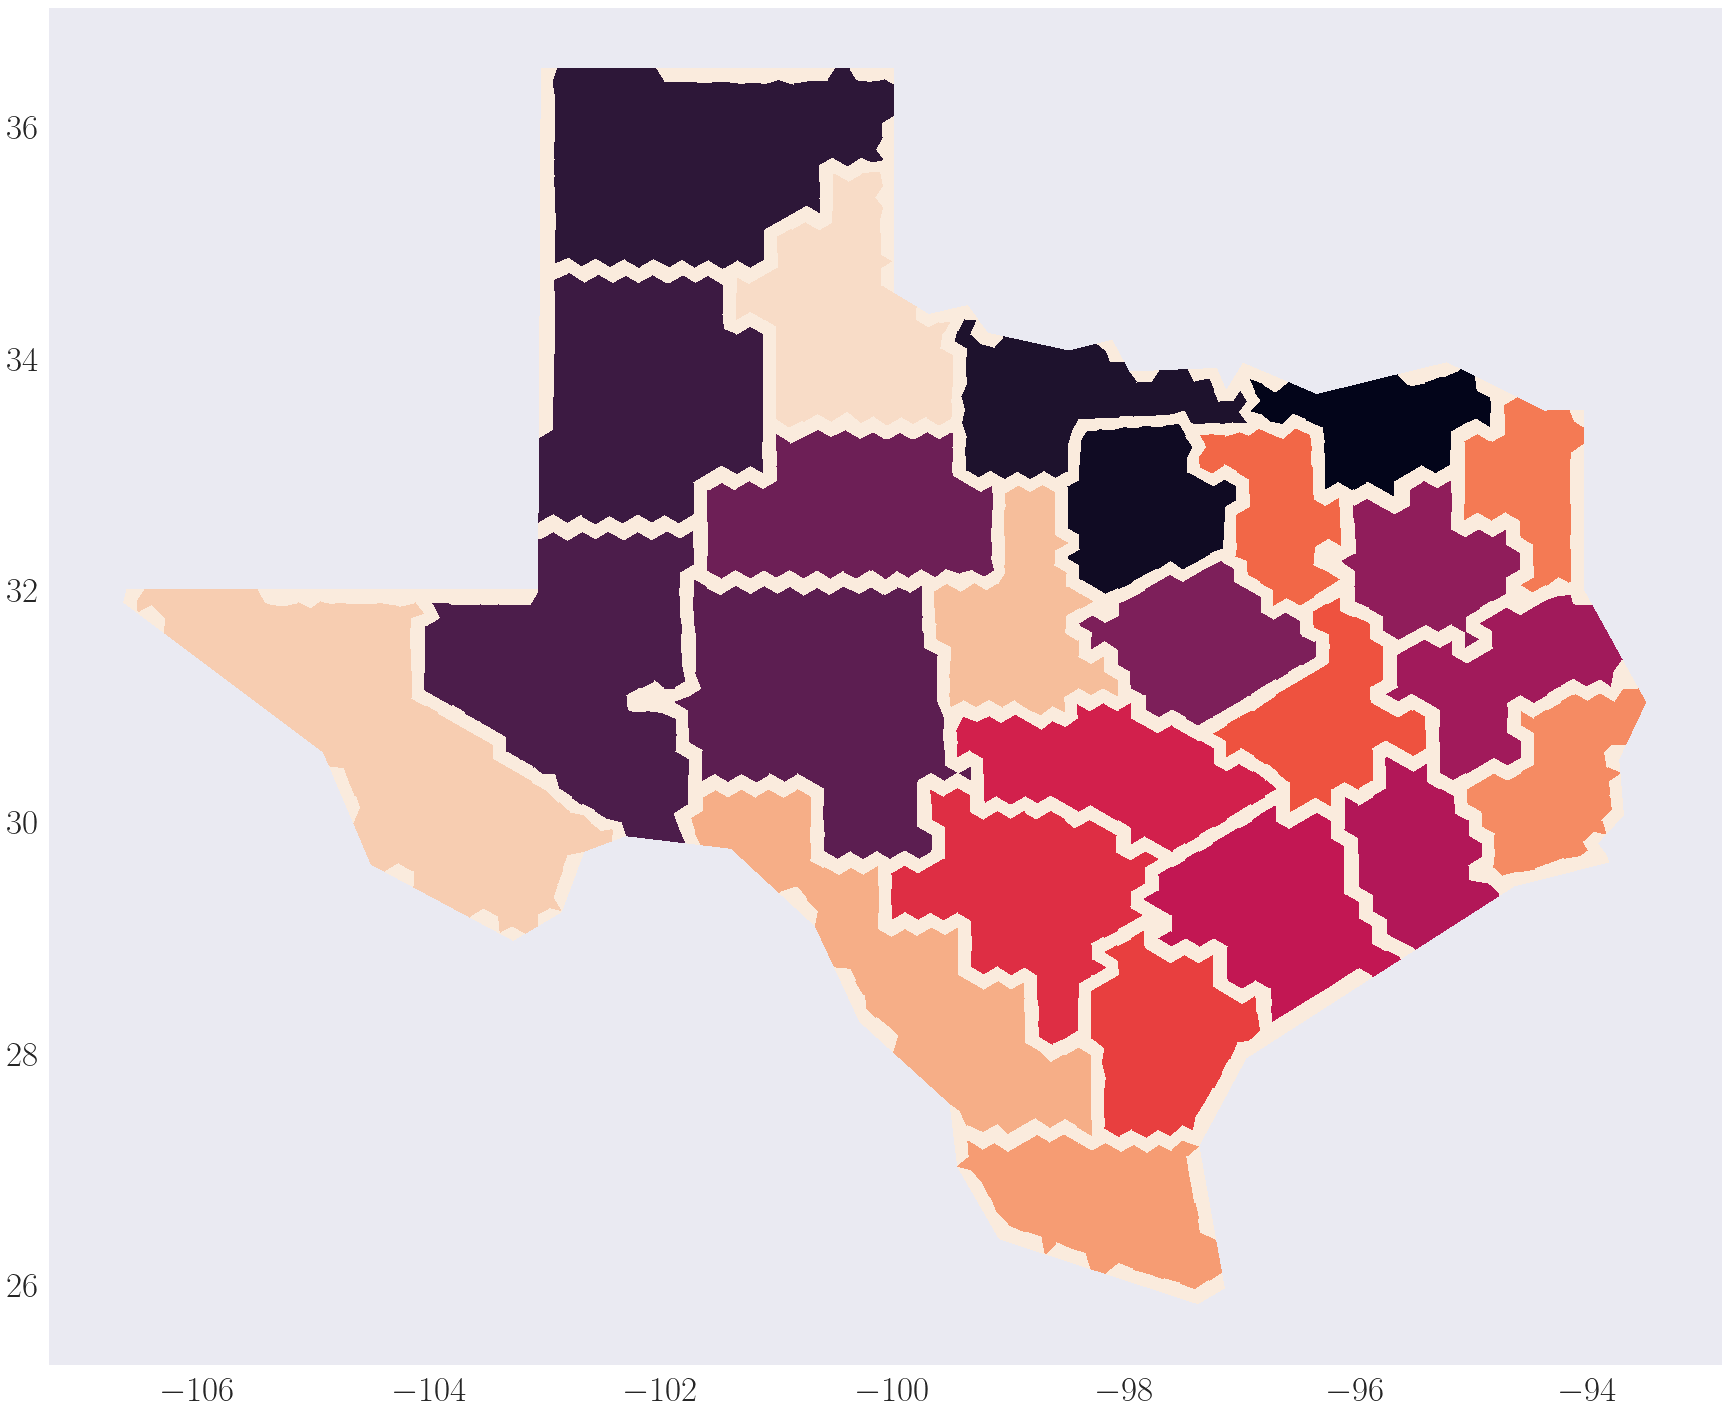

In [24]:
subdomain = dl.MeshFunction("size_t", mesh, 2)
# tag total domain as 25
subdomain.set_all(25)

dist_subdmns = [DistrictSubDomain() for i in range(25)]
for i in range(25):
    dist_subdmns[i].set(district=i, dist_geom = new_dist_geom)
    dist_subdmns[i].mark(subdomain, i)

fig = plt.figure(figsize=(30, 30))
plt.autoscale(enable=True, axis='both')
dl.plot(subdomain)

In [19]:
# save to file
dl.File(fwd_path + 'subdomains/subdomain_' + mesh_fname + '.xml.gz') << subdomain

In [20]:
# read from file
# subdomain = dl.MeshFunction("size_t", mesh, 2)
# dl.File(fwd_path + 'subdomains/subdomain_' + mesh_fname + '.xml.gz') >> subdomain

In [21]:
# dx_dist = [dl.Measure('dx', domain=mesh, subdomain_data=indicator_fns_test_2[i]) for i in range(25)]
dx_dist = dl.Measure('dx', domain=mesh, subdomain_data=subdomain)
dx = dl.Measure('dx', domain=mesh)

In [22]:
area_dist_cal = [0. for i in range(25)]
area_dist_act = [0. for i in range(25)]
factor_dist_area = [1. for i in range(25)]
for i in range(25):
    area_dist_cal[i] = dl.assemble(dl.Constant(1.0)*dl.Constant(1.0)*dx_dist(i))
    area_dist_act[i] = new_dist_geom[i].area
    factor_dist_area[i] = area_dist_act[i] / area_dist_cal[i]
    print('district: {0:<5} actual area: {1:<5} computed area: {2:<5} factor: {3}'.format(i, 
                        area_dist_act[i], area_dist_cal[i], factor_dist_area[i]))
    
print('actual total area: {0:<5} sum dist area: {1:<5} comp total are: {2}'.format(
    np.sum(area_dist_act), np.sum(area_dist_cal), dl.assemble(dl.Constant(1.0)*dl.Constant(1.0)*dx)))

np.save(fwd_path + 'subdomains/area_factor_' + mesh_fname + '.npy', factor_dist_area)

district: 0     actual area: 1.6014532991460728 computed area: 1.1688081725200226 factor: 1.370159224411685
district: 1     actual area: 1.7669818681646594 computed area: 1.366399373694687 factor: 1.2931664798607263
district: 2     actual area: 2.0662926054099713 computed area: 1.573671437267686 factor: 1.3130394035730908
district: 3     actual area: 4.620645546913652 computed area: 3.728251456663978 factor: 1.239359952144479
district: 4     actual area: 4.003143226849417 computed area: 3.3302719720169676 factor: 1.2020469380538092
district: 5     actual area: 4.50638253516794 computed area: 3.7843955408383136 factor: 1.1907800034479727
district: 6     actual area: 4.675189903657626 computed area: 3.9392829183015756 factor: 1.1868124226206471
district: 7     actual area: 2.951891729466009 computed area: 2.35556315180475 factor: 1.2531575420528942
district: 8     actual area: 1.9030156496708315 computed area: 1.4950693274585056 factor: 1.2728611407644894
district: 9     actual area: 1.6

In [26]:
# create data
def create_subdomain_data(mesh_files):
    area_factors = []
    for file in mesh_files:
        mesh = dl.Mesh(mesh_path + file + ".xml")
        
        subdomain = dl.MeshFunction("size_t", mesh, 2)
        # tag total domain as 25
        subdomain.set_all(25)

        dist_subdmns = [DistrictSubDomain() for i in range(25)]
        for i in range(25):
            dist_subdmns[i].set(district=i, dist_geom = new_dist_geom)
            dist_subdmns[i].mark(subdomain, i)
            
        # save to file
        dl.File(fwd_path + 'subdomains/subdomain_' + file + '.xml.gz') << subdomain
        
        # dx_dist = [dl.Measure('dx', domain=mesh, subdomain_data=indicator_fns_test_2[i]) for i in range(25)]
        dx_dist = dl.Measure('dx', domain=mesh, subdomain_data=subdomain)
        dx = dl.Measure('dx', domain=mesh)
        
        area_dist_cal = [0. for i in range(25)]
        area_dist_act = [0. for i in range(25)]
        factor_dist_area = [1. for i in range(25)]
        for i in range(25):
            area_dist_cal[i] = dl.assemble(dl.Constant(1.0)*dl.Constant(1.0)*dx_dist(i))
            area_dist_act[i] = new_dist_geom[i].area
            factor_dist_area[i] = area_dist_act[i] / area_dist_cal[i]
        
        np.save(fwd_path + 'subdomains/area_factor_' + file + '.npy', factor_dist_area)
        
        
        area_factors.append(factor_dist_area)
        
    return area_factors

mesh_files = ['mesh_5h', 'mesh_4h', 'mesh_2h', 'mesh_h', 'mesh_0.5h']
area_factors = create_subdomain_data(mesh_files)

NameError: name 'area_factors' is not defined

In [31]:
# create data
def read_subdomain_data(mesh_files):
    area_factors = []
    for file in mesh_files:
        mesh = dl.Mesh(mesh_path + file + ".xml")
        
        subdomain = dl.MeshFunction("size_t", mesh, 2)
        
        dl.File(fwd_path + 'subdomains/subdomain_' + file + '.xml.gz') >> subdomain
        
        # dx_dist = [dl.Measure('dx', domain=mesh, subdomain_data=indicator_fns_test_2[i]) for i in range(25)]
        dx_dist = dl.Measure('dx', domain=mesh, subdomain_data=subdomain)
        dx = dl.Measure('dx', domain=mesh)
        
        area_dist_cal = [0. for i in range(25)]
        area_dist_act = [0. for i in range(25)]
        factor_dist_area = [1. for i in range(25)]
        for i in range(25):
            area_dist_cal[i] = dl.assemble(dl.Constant(1.0)*dl.Constant(1.0)*dx_dist(i))
            area_dist_act[i] = new_dist_geom[i].area
            factor_dist_area[i] = area_dist_act[i] / area_dist_cal[i]
        
        
        area_factors.append(factor_dist_area)
        
    return area_factors

area_factors = read_subdomain_data(mesh_files)

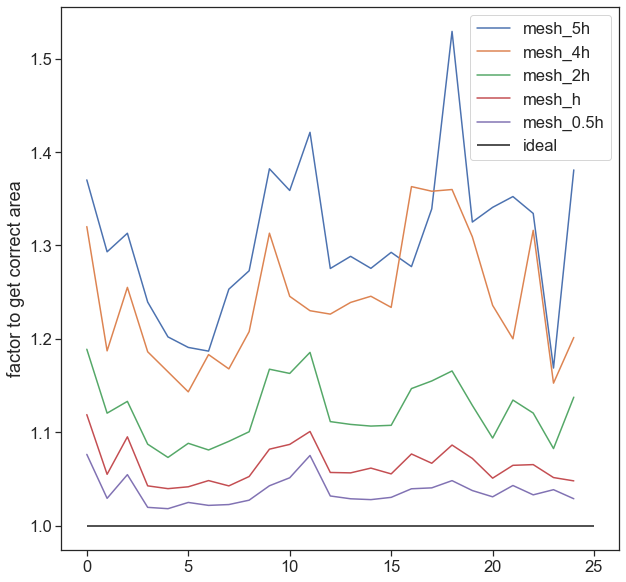

In [41]:
from matplotlib import rc
rc("text", usetex=False)
fig = plt.figure(figsize=(10, 10))
plt.autoscale(enable=True, axis='both')
plt.hlines(1., 0., 25., label='ideal')
for i in range(len(mesh_files)):
    plt.plot(area_factors[i], label=mesh_files[i])
plt.ylabel('factor to get correct area')
# plt.xlabel('districts')
plt.legend()
plt.savefig('area_factors_for_different_meshes.pdf')
plt.show()

# Setup function space and pde

In [6]:
FE_polynomial = 1
Vu = dl.FunctionSpace(mesh, "Lagrange", FE_polynomial)

# save data 
d0 = datetime.datetime.strptime("2020-03-06", "%Y-%m-%d")
d1 = datetime.datetime.strptime(date, "%Y-%m-%d")
day_index = abs((d1-d0)).days

# Define elements: P1 and real number
P1  = dl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
R   = dl.FiniteElement("R", mesh.ufl_cell(), 0)

# Define differen scenario
param_dim = 7

# Define the parameter space: R^7
Vh_PARAMETER = dl.VectorFunctionSpace(mesh, "R", degree=0, dim=param_dim)

# Define the state space for each species
Vh = [Vu, Vh_PARAMETER, None]

In [ ]:
dl.plot(mesh)

In [ ]:
mesh_vh = Vh[STATE].mesh()
dl.plot(mesh_vh)

## create kernel for integration over districts

In [ ]:
p = dl.TestFunction(Vh[STATE])

# for integration over whole domain
z = dl.assemble(dl.Constant(1.0)*p*dl.dx)

# for integration over districts
z_dist = [dl.assemble(dl.Constant(1.0)*p*dx_dist(i)) for i in range(25)]

## Simulation time 

In [7]:
# about september 19
# simulation_time = 110.
simulation_time = 2.
dt = 0.1

u_init = [None]*5
names = ["susceptible", "exposed", "infected", "recovered", "deceased"]
for i in range(5):
    u_init[i] = np.load(ic_path + names[i] + '_ic.npy')

# define pde
pde = seird_fwd_problem(Vh, simulation_time, dt, u_init, 
                        subdmn_path = fwd_path + 'subdomains/', mesh_tag=mesh_fname)

In [8]:
# load parameter samples
param_samples = np.load(samples_path + 'validation_posterior_samples.npy')

# get sims and sim id
if num_sim == 0 or num_sim == sim_id:
    raise IndexError('Number of sim or sim id is invalid')

# output and log paths
qoi_path = out_path + '/qoi/'
log_path = out_path + '/log/'
# sys.stdout = open(log_path + 'sim_' + str(sim_id) + '.log', 'w')
# print('\n\nsim id: {0:<8} num sim: {1}\n\n'.format(sim_id, num_sim))

# solve
sim_time = []
qoi = []
counter = 0
current_run = 0

for param in param_samples:
    
    if counter > 1:
        break

    if counter % num_sim == sim_id:

        print('\n\nsimulation counter: {}\n'.format(counter))

        start = timeit.default_timer()

        #### solve for current sample
        x = [pde.generate_state_district(), pde.generate_parameter(), None]
        #x = [pde.generate_state(), pde.generate_parameter(), None]
        m_test = np.array(param)

        x[PARAMETER].set_local(m_test)
        pde.solveFwd(x[STATE], x)

        # save QoI
        qoi.append(x[STATE])
        np.save(qoi_path + 'qoi_' + str(sim_id) + '.npy', qoi)

        stop = timeit.default_timer()
        sim_time.append(stop - start)

        current_run += 1

    counter += 1


# save QoI
np.save(qoi_path + 'qoi_' + str(sim_id) + '.npy', qoi)

# output mean time
# print('mean sim time: {}'.format(np.mean(sim_time)))






simulation counter: 0



NameError: name 'u' is not defined

In [ ]:
# print(qoi)
qoi[0].shape  # (num_days, 26, 2)